<img src="../../images/wt4.png" align="right" width="70"/>

  #     Notebook for early bearing fault detection for WT04



## Table of contents
1. Raw signal
2. Resampled signal
3. Filtered signal with optimal bandpass based on SK
4. Demodulasation using EEMD signals
5. Selecting IMF: Correlation coefficient
6. Envelope spectral analyis
7. Frequency study

In [1]:
%load_ext autoreload

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys, os,os.path
import matplotlib.pyplot as plt

ROOT_PATH = os.path.abspath("..").split("data_processing")[0]
module_paths = []
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/data_processing/")))
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/hybrid_analysis_process_functions/")))
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/utils/")))
for module_path in module_paths:
    if module_path not in sys.path:
        print("appended")
        sys.path.append(module_path)
import functions as f
%autoreload
import wt_data, ff_transform, explore_fft_time_data, envelope, build_dataset, load_raw_signals, envelope, envelope_emd
import resample_signals, filter_signals, plotting_methods


appended
appended
appended
ROOT /Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src
/Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src
ROOT /Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src
ROOT /Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src
ROOT /Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src


## 1. Raw signal 

In [3]:
vib_signal, times, op_data_intervals, peak_array = load_raw_signals.load_raw('gearbox','wt04')
avg_rpm = np.asarray(op_data_intervals['AvgSpeed'])
avg_power = np.asarray(op_data_intervals['AvgPower'])

File exist


5
110886912


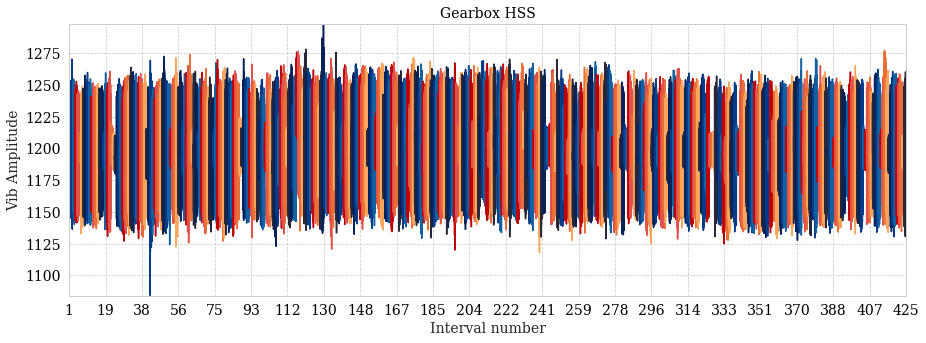

In [4]:
envelope.plot_vib_consecutive(vib_signal)

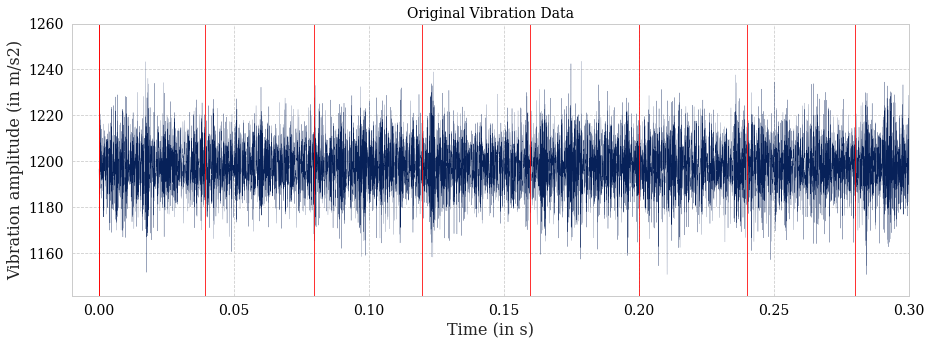

In [5]:
i=67
plotting_methods.plot_signal(times[i], vib_signal[i], peak_array=peak_array[i], x_min=-0.01, x_max=0.3, name='Original')


### Filter out the first 2000Hz

In [ ]:
low_cut = 2000
filtered_raw_vib = []
vib_signal_size = len(vib_signal)

for i, vib_sig in enumerate(vib_signal):
    flitered_vib_sig = filter_signals.do_high_pass_filter(vib_sig, low_cut)
    filtered_raw_vib.append(flitered_vib_sig)
    print(f'Filtered {i+1} / {vib_signal_size} signals', end='\r')
filtered_raw_vib = np.asarray(filtered_raw_vib)

### Plot FFT of raw and filtered raw for verification

In [ ]:
i = 1
plotting_methods.plot_fft(times[i], vib_signal[i], avg_power=avg_power[i], avg_rpm=avg_rpm[i], interval_num=i)

In [ ]:

plotting_methods.plot_fft(times[i], filtered_raw_vib[i], avg_power=avg_power[i], avg_rpm=avg_rpm[i], interval_num=i)

#### Save filtered, raw vibration signal to CSV

In [ ]:
'''
path = '/Volumes/OsvikExtra/signal_data/raw_filtered_2000Hz/gearbox/wt04/';
list_size = len(filtered_raw_vib)
for i, vib_sig in enumerate(filtered_raw_vib):
    np.savetxt(f'{path}filtered_raw_{i}.csv', vib_sig, delimiter=',')
    print(f'Saved {i+1} / {list_size} files', end='\r')
'''

### Filter out the first 6000Hz

In [6]:
low_cut = 6000
filtered_raw_vib_6000 = []
vib_signal_size = len(vib_signal)

for i, vib_sig in enumerate(vib_signal):
    flitered_vib_sig = filter_signals.do_high_pass_filter(vib_sig, low_cut)
    filtered_raw_vib_6000.append(flitered_vib_sig)
    print(f'Filtered {i+1} / {vib_signal_size} signals', end='\r')
filtered_raw_vib_6000 = np.asarray(filtered_raw_vib_6000)

### Plot FFT of raw and filtered raw for verification

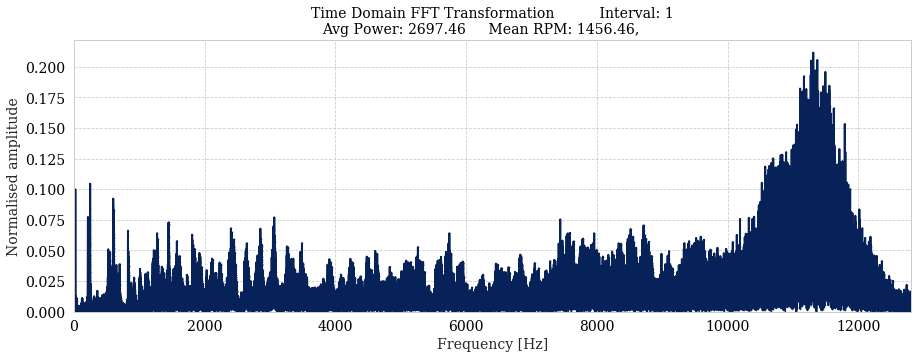

In [7]:
i = 1
plotting_methods.plot_fft(times[i], vib_signal[i], avg_power=avg_power[i], avg_rpm=avg_rpm[i], interval_num=i)

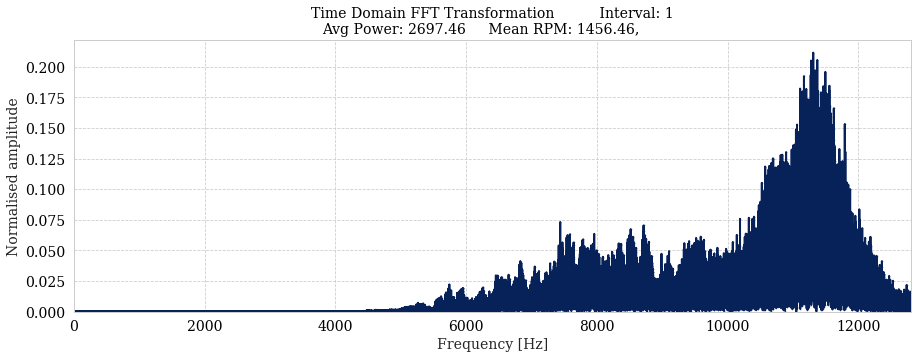

In [8]:
plotting_methods.plot_fft(times[i], filtered_raw_vib_6000[i], avg_power=avg_power[i], avg_rpm=avg_rpm[i], interval_num=i)


#### Save filtered, raw vibration signal to CSV

In [10]:

path = '/Volumes/OsvikExtra/signal_data/raw_filtered_6000Hz/gearbox/wt04/';
list_size = len(filtered_raw_vib_6000)
for i, vib_sig in enumerate(filtered_raw_vib_6000):
    np.savetxt(f'{path}filtered_raw_6000_{i}.csv', vib_sig, delimiter=',')
    print(f'Saved {i+1} / {list_size} files', end='\r')


## 2. Resampled signal

In [ ]:
# Linear Interpolation

time = times[0]
resampled_vib_signal = []
resampled_time_signal = []

for i, vib_sig in enumerate(vib_signal):
    resampled_round, resampled_y, resampled_time = resample_signals.do_linear_resampling(
        time, 
        vib_sig, 
        peak_array[i],
        number_of_resample_points=1500
    )
    
    resampled_time_signal.append(resampled_time)
    resampled_vib_signal.append(resampled_y)
    print(f'Resampled {i+1} / {vib_signal_size} signals', end='\r')

In [ ]:
i = 203
plotting_methods.plot_fft(resampled_time_signal[i], resampled_vib_signal[i], avg_power=avg_power[i], avg_rpm=avg_rpm[i], interval_num=i)

### 2.5 Filter out the first 2000 Hz

In [ ]:
low_cut = 2000
filtered_resampled_vib = []
resampled_vib_signal_size = len(resampled_vib_signal)

skip = 0
for i, vib_sig in enumerate(resampled_vib_signal):
    if len(vib_sig) < 100000:
        filtered_resampled_vib.append(vib_sig)
        skip +=1
        continue
    flitered_vib_sig = filter_signals.do_high_pass_filter(vib_sig, low_cut)
    filtered_resampled_vib.append(flitered_vib_sig)
    print(f'Filtered {i+1} / {resampled_vib_signal_size} resampled signals', end='\r')

In [ ]:
i = 0
plotting_methods.plot_fft(resampled_time_signal[i], filtered_resampled_vib[i], avg_power=avg_power[i], avg_rpm=avg_rpm[i], interval_num=i)

### Save filtered resampled vibration signal to CSV

In [ ]:
'''
path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/';
list_size = len(filtered_resampled_vib)
for i, vib_sig in enumerate(filtered_resampled_vib):
    time_and_vib = np.array([resampled_time_signal[i], vib_sig])
    time_and_vib_pd = pd.DataFrame(time_and_vib.T, columns=['Time', 'VibrationSignal'])
    time_and_vib_pd.to_csv(f'{path}filtered_resampled_{i}.csv', sep=',', header=time_and_vib_pd.columns)
    print(f'Saved {i+1} / {list_size} files', end='\r')
'''

## 3. Filtered signal with optimal bandpass based on SK

In [11]:
# Read kurtogram data
fc_and_bw_path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/center_frequencies_&_bandwidth/fc_and_bw_data.csv';
frequencies_path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/center_frequencies_&_bandwidth/frequencies.csv';
file_names_path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/center_frequencies_&_bandwidth/file_name.txt';

fc_and_bw = pd.read_csv(fc_and_bw_path)
frequencies = pd.read_csv(frequencies_path)
file_names = pd.read_csv(file_names_path, header=None)

frequencies_numpy = np.asarray(frequencies).T
frequencies = pd.DataFrame(frequencies_numpy, columns= frequencies_numpy[0])
frequencies = frequencies.drop(frequencies.index[0]).reset_index(drop=True)
fc_and_bw

,File,Frequencies,Bandwidths
0,filtered_resampled_0.csv,10376.016144,4150.406458
1,filtered_resampled_1.csv,12771.655165,567.629118
2,filtered_resampled_10.csv,12720.156556,565.340291
3,filtered_resampled_100.csv,12731.600691,286.103386
4,filtered_resampled_101.csv,12757.349996,280.381319
5,filtered_resampled_102.csv,13090.946544,70.953640
6,filtered_resampled_103.csv,12792.254609,370.789989
7,filtered_resampled_104.csv,12949.611472,69.809226
8,filtered_resampled_105.csv,12830.401727,382.997066
9,filtered_resampled_106.csv,12651.491743,460.054245


In [80]:
dir_path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/kurtograms/';
count = 0
for filename in os.listdir(dir_path):
    if filename.endswith('.csv'):
        print(filename.split('_')[])
        count+=1

['kgram', 'filtered', 'resampled', '0.csv']
['kgram', 'filtered', 'resampled', '1.csv']
['kgram', 'filtered', 'resampled', '10.csv']
['kgram', 'filtered', 'resampled', '100.csv']
['kgram', 'filtered', 'resampled', '101.csv']
['kgram', 'filtered', 'resampled', '102.csv']
['kgram', 'filtered', 'resampled', '103.csv']
['kgram', 'filtered', 'resampled', '104.csv']
['kgram', 'filtered', 'resampled', '105.csv']
['kgram', 'filtered', 'resampled', '106.csv']
['kgram', 'filtered', 'resampled', '107.csv']
['kgram', 'filtered', 'resampled', '108.csv']
['kgram', 'filtered', 'resampled', '109.csv']
['kgram', 'filtered', 'resampled', '11.csv']
['kgram', 'filtered', 'resampled', '110.csv']
['kgram', 'filtered', 'resampled', '111.csv']
['kgram', 'filtered', 'resampled', '112.csv']
['kgram', 'filtered', 'resampled', '113.csv']
['kgram', 'filtered', 'resampled', '114.csv']
['kgram', 'filtered', 'resampled', '115.csv']
['kgram', 'filtered', 'resampled', '116.csv']
['kgram', 'filtered', 'resampled', '117.

In [12]:
kurt_path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/kurtograms/';
kurt_file = f'{kurt_path}kgram_filtered_resampled_206.csv'
kurtogram = pd.read_csv(kurt_file, header=None)

In [76]:
%autoreload
plotting_methods

<module 'plotting_methods' from '/Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src/hybrid_analysis_process_functions/plotting_methods.py'>

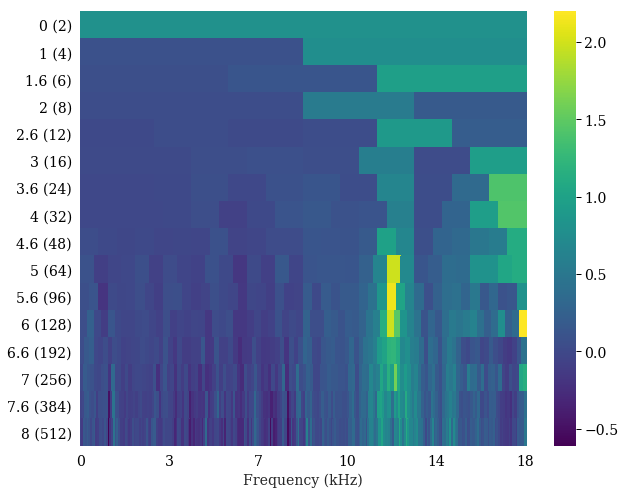

In [77]:
plotting_methods.plot_kurtogram(kurtogram, frequencies['filtered_resampled_206.csv'])

## 4. Demodulasation using EEMD signals

In [ ]:
from PyEMD import EEMD
import numpy as np
import pylab as plt
# Define signal
S = vib_signal[0][0:10000]
t = times[0][0:10000]

# Assign EEMD to `eemd` variable
eemd = EEMD()
# Say we want detect extrema using parabolic method
emd = eemd.EMD
emd.extrema_detection="parabol"
# Execute EEMD on S
eIMFs = eemd.eemd(S, t)
nIMFs = eIMFs.shape[0]
# Plot results
plt.figure(figsize=(12,9))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(t, S, 'r')


In [ ]:
envelope_emd.eemd('WT01',1,'gearbox',vib_signal[0][0:10000],times[0][0:10000],True)

## 5. Selecting IMF: Correlation coefficient

## 6. Envelope spectral analysis

## 7. Frequency study (fault characteristics), fault development